# Модели распространения в сложных сетях

In [1]:
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline
import networkx as nx
import pandas as pd

Будем предполагать, что вершина сети может находиться в одном из следующих состояний:
* S-  susceptible (здоровый, может быть заражен);
* I - infectious  (больной, может заразить других);
* R-  recovered   (переболевший, обладает иммунитетом).

Введем следующие обозначения:
* $x=\frac{I}{N}$ - доля больных;
* $y=\frac{S}{N}$ - доля здоровых;
* $z=\frac{R}{N}$ - доля невосприимчивых;

## 1. SI  
### Приближение среднего поля
Схематически записывается: 
$$
S+I  \xrightarrow{\beta} I+I
$$

Уравнение, описывающее динамику в системе:

$$
\frac{dx}{dt}=\beta \left<k\right>x(1-x),
$$
где $\beta$- вероятность передачи инфекции в единицу времени, $\left<k\right>$ - средняя степень вершины (среднее число контактов человека). Решение уравнения:
$$
x=\frac{x_0e^{\beta \left<k\right>t}}{1-x_0+x_0e^{\beta \left<k\right>t}}
$$

In [2]:
def si_func(x0,beta_k,t):
    return x0*np.exp(beta_k*t)/(1-x0+x0*np.exp(beta_k*t))

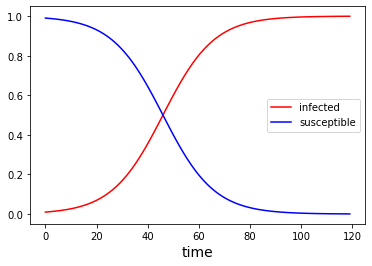

In [3]:
beta_k=0.1
n_iter=120
t=np.linspace(0,n_iter-1,n_iter)
plt.plot(t,si_func(0.01,beta_k,t),color='r',label='infected')
plt.plot(t,1-si_func(0.01,beta_k,t),color='b', label='susceptible')
plt.xlabel('time',fontsize=14)
plt.legend()

### Распространение на сети
Реализацию алгоритма можно найти в библиотеке [NDlib](https://ndlib.readthedocs.io/en/latest/index.html). 
Построим модель SI на случайном графе Эрдеша-Реньи:

In [6]:
from tqdm import tqdm
import ndlib.models.epidemics as si
import ndlib.models.ModelConfig as mc

In [7]:
N=1000
beta=0.01 
G=nx.erdos_renyi_graph(N,0.01)
si_model = si.SIModel(G) #
config = mc.Configuration()
config.add_model_parameter('beta', beta)
config.add_model_parameter("percentage_infected", 0.01)
si_model.set_initial_status(config)
iterations = si_model.iteration_bunch(n_iter)
susceptible, infected= [],[]
for iteration in iterations:
    node_count = iteration['node_count']
    susceptible.append(node_count[0]/N)
    infected.append(node_count[1]/N)

100%|██████████| 120/120 [00:00<00:00, 392.28it/s]


Text(0, 0.5, 'fraction of infected, x')

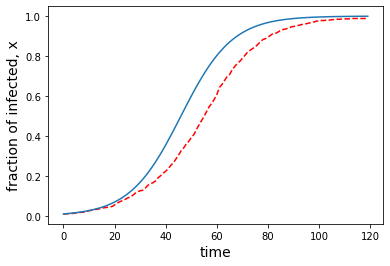

In [8]:
plt.plot(t,infected,'--',color='r')
plt.plot(t,si_func(0.01,beta_k,t))
plt.xlabel('time',fontsize=14)
plt.ylabel('fraction of infected, x',fontsize=14)

Модель чувствительна к начальным условиям и топологии сети, сделаем усреднение по 100 реализациям:

In [10]:
n_run=100
stats = {'susceptible' : [],
             'infected': []}
    
for i in tqdm(range(n_run)):
    G=nx.erdos_renyi_graph(N,0.01)
    si_model = si.SIModel(G) #
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter("percentage_infected", 0.01)
    si_model.set_initial_status(config)
    iterations = si_model.iteration_bunch(n_iter)
    suspectible, infected= [],[]
    for iteration in iterations:
        node_count = iteration['node_count']
        suspectible.append(node_count[0]/N)
        infected.append(node_count[1]/N)

    stats['susceptible'].append(susceptible)
    stats['infected'].append(infected)
    
s1=[np.mean(np.array(stats['infected']), axis=0),
            np.std(np.array(stats['infected']), axis=0)]

 23%|██▎       | 28/120 [00:00<00:00, 273.79it/s]


100%|██████████| 120/120 [00:00<00:00, 347.83it/s]


  0%|          | 0/120 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


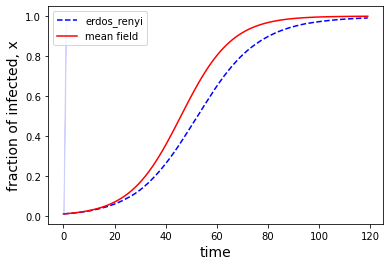

In [11]:
plt.fill_between( s1[0],s1[0] - s1[1], s1[0] + s1[1], 
                 alpha = 0.15, color = 'b')

plt.plot(t,s1[0],'--',color='b', label='erdos_renyi')
plt.plot(t,si_func(0.01,beta_k,t),color='r',label='mean field')
plt.xlabel('time',fontsize=14)
plt.ylabel('fraction of infected, x',fontsize=14)
plt.xlabel('time',fontsize=14)
plt.ylabel('fraction of infected, x',fontsize=14)
plt.legend()

## 2. Модель SIS 
### Приближение среднего поля:
Схематически записывается: 
$$
S+I  \xrightarrow{\beta} I+I \\
I  \xrightarrow{\mu}S
$$

Уравнение, описывающее динамику в системе:

$$
\frac{dx}{dt}=\beta \left<k\right>x(1-x)-\mu x.  
$$ 

Решение:
$$
x=\left( 1-\frac{\mu}{\beta \left<k\right>}\right)\frac{Ce^{(\beta \left<k\right>-\mu) t}}{1+Ce^{\beta \left<k\right>t}},
$$
где 

$$
C=x_0/(1-x_0-\mu/\beta \left<k\right>).
$$

### Распространение на сети 

In [8]:
import ndlib.models.epidemics.SISModel as sis

Реализация модели SIS на примере сети клуб-каратэ (пример из лекции):

In [9]:
G = nx.karate_club_graph()
sis_model = sis.SISModel(G)
config = mc.Configuration()
config.add_model_parameter('beta', 0.35)
config.add_model_parameter('lambda', 0.5)
config.add_model_parameter("percentage_infected", 0.03)
sis_model.set_initial_status(config)
iterations = sis_model.iteration_bunch(10)

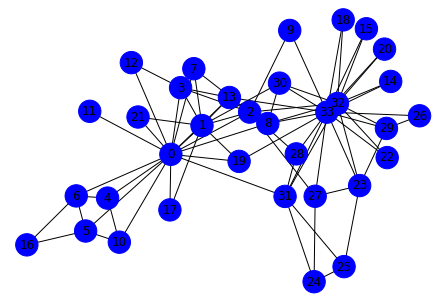

In [10]:
colors=['b']*G.number_of_nodes()
pos=nx.spring_layout(G,iterations=400)
nx.draw(G,pos,node_size=500, node_color=colors, with_labels=True)

Первый момент времени:

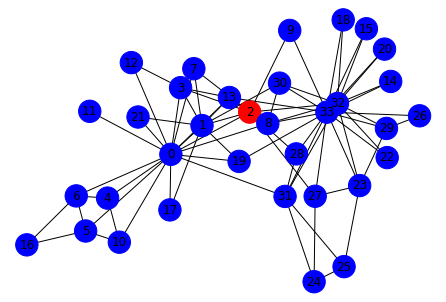

In [11]:
for node in iterations[0]['status']:
    if(iterations[0]['status'][node]==1):
        colors[node]='r'
nx.draw(G,pos,node_size=500, node_color=colors, with_labels=True)

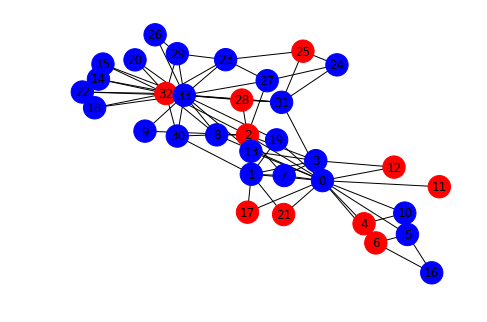

In [19]:
j=8
for node in iterations[j]['status']:
    if(iterations[j]['status'][node]==1):
        colors[node]='r'
    else:
        colors[node]='b'

nx.draw(G,pos,node_size=500, node_color=colors, with_labels=True)

## 3. Модель SIR 
### Приближение среднего поля 
Схематически записывается: 
$$
S+I  \xrightarrow{\beta} I+I \\
I  \xrightarrow{\mu}R
$$

Уравнение, описывающее динамику в системе:

$$
\frac{dx}{dt}=\beta \left<k\right>x(1-x-z)-\mu x \\  
\frac{dy}{dt}=-\beta \left<k\right>x(1-x-z)\\  
\frac{dz}{dt}=\mu x.
$$ 

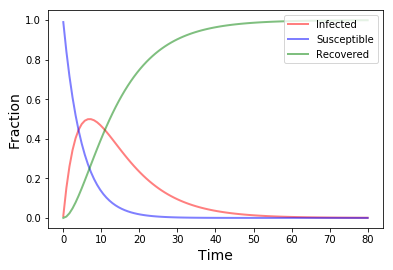

In [20]:
from scipy.integrate import odeint
# The SIR model differential equations.
def deriv(s0, t, beta_k, mu):
    x, y, z = s0 #
    dxdt = beta_k * (1-x-z)- mu* x
    dydt = -beta_k * (1-x-z)
    dzdt = mu * x
    return dxdt, dydt, dzdt


beta_k, mu = 0.2, 1./10 # model parameters
s0 = 0.01, 0.99, 0
t=np.linspace(0,80,100)

ret = odeint(deriv, s0, t, args=( beta_k, mu))
x, y, z = ret.T

plt.plot(t, x, 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(t, y, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(t, z, 'g', alpha=0.5, lw=2, label='Recovered')
plt.xlabel('Time',fontsize=14)
plt.ylabel('Fraction',fontsize=14)
plt.legend(loc='upper right')

### Распространение на сети

In [21]:
N=1000

import ndlib.models.epidemics.SIRModel as sir
G=nx.erdos_renyi_graph(N,0.1)
sir_model = sir.SIRModel(G)
config = mc.Configuration()
config.add_model_parameter('beta', 0.005)
config.add_model_parameter('gamma',0.03)
config.add_model_parameter("percentage_infected", 0.02)
sir_model.set_initial_status(config)
iterations = sir_model.iteration_bunch(150)
susceptible,infected,recovered = [],[],[]
 
for iteration in iterations:
    node_count = iteration['node_count']
    susceptible.append(node_count[0]/N)
    infected.append(node_count[1]/N)
    recovered.append(node_count[2]/N)

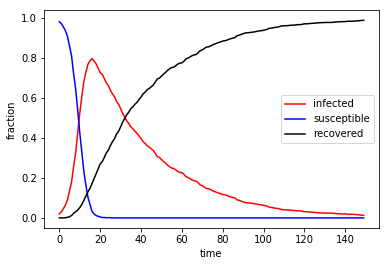

In [22]:
plt.plot(infected,color='r',label='infected')
plt.plot(susceptible, color='b',label='susceptible')
plt.plot(recovered, color='k',label='recovered')
plt.xlabel('time')
plt.ylabel('fraction')
plt.legend()